In [1]:
try:
    %matplotlib inline
    %load_ext autoreload
    %autoreload 2
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:100% !important; }</style>"))
except:
    pass

In [2]:
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [3]:
#!pip3 install albumentations

In [4]:
import pandas as pd
import numpy as np
from skimage.transform import rescale

In [5]:
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
device

device(type='cuda')

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2 
import time

In [8]:
np.random.seed(seed=sum([ord(c) for c in 'wheat']))
torch.manual_seed(seed=sum([ord(c) for c in 'Bier']))
target_size = 224
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
def load_data(env):
    if(env == 'kaggle'):
        data_path = '/kaggle/input/global-wheat-detection'
    elif(env == 'local'):
        data_path = '../wheat_data/'
    elif(env == 'colab'):
        from google.colab import drive
        drive.mount('/content/drive')
        data_path = '/content/drive/My Drive/wheat_net/wheat_data/'
    else:
        print("Not availible enviroment")
        return None
    train_df = pd.read_csv(f'{data_path}/train.csv')
    submit = pd.read_csv(f'{data_path}/sample_submission.csv')
    return data_path,train_df,submit




In [10]:
def read_img(img_str, target_size):
    img = cv2.imread(img_str, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (target_size, target_size))
    return img

In [11]:
#np.random.randint(0,4,100)

In [12]:
def random_rotation(img,boxes):
  p=np.random.randint(0,4)
  fw,fh,_ = img.shape
  new_box = np.zeros_like(boxes)

  if(p==0):
    return img,boxes
  
  if(p==1):
      img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE) ## wierd coordinate ...
      for i in range(len(boxes)):
        x,y,w,h = boxes[i]
        new_box[i] = [fh-h-y,x,h,w]

  if(p==2):
      img = cv2.rotate(img, cv2.ROTATE_180)
      for i in range(len(boxes)):
        x,y,w,h = boxes[i]
        new_box[i] = [fw-w-x,fh-h-y,w,h]

  if(p==3):
      img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
      for i in range(len(boxes)):
        x,y,w,h = boxes[i]
        new_box[i] = [y,fw-w-x,h,w]
  #print("p=",p)
  return img,new_box

In [13]:
def load_figure(df,data_path,test_or_train):
    image_dict={}
    image_list=df['image_id'].unique()

    for i,image_id in enumerate(image_list):
        if(test_or_train=="train"):
            image=read_img(f'{data_path}/train/{image_id}.jpg',target_size).astype(np.float32)
        elif(test_or_train=="test"):
            image=read_img(f'{data_path}/test/{image_id}.jpg',target_size).astype(np.float32)

        image_dict[image_id]=image.astype(np.float32)
        if(i%(int(len(image_list)*0.1))==0):
            print("process", float(i)/len(image_list))
    print("process", 1.0)
    return image_dict

In [14]:
data_path,train_df,submit = load_data(env = 'local')

In [15]:
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [16]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    x=x.replace('[','')
    x=x.replace(']','')
    x = x.split(',')
    y = np.array(x)
    if(len(y)!=4):
        y = np.array([-1,-1,-1,-1]) 
    return y

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)

In [17]:
train_df=train_df[train_df.x!=-1] # actually not used
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

train_df['x_scale'] = target_size/train_df['width']
train_df['y_scale'] = target_size/train_df['height']

train_df['x']*=train_df['x_scale']
train_df['y']*=train_df['y_scale'] 
train_df['w']*=train_df['x_scale']
train_df['h']*=train_df['y_scale'] 

In [18]:
image_ids = train_df['image_id'].unique()
sample_id = np.random.choice(image_ids)

b6ab77fd7


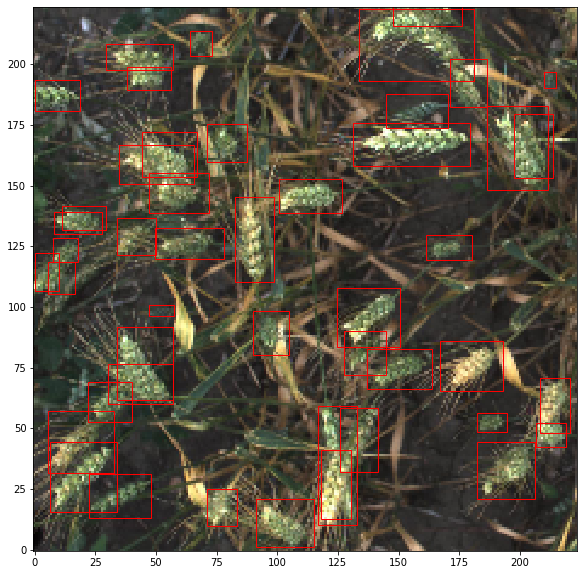

In [19]:
size = 10
sample_id  = list(train_df['image_id'])[0]
img = read_img(f'{data_path}/train/{sample_id}.jpg',target_size)
boxes = train_df[train_df.image_id == sample_id ][['x', 'y', 'w', 'h']].values
scale = train_df[train_df.image_id == sample_id ][['x_scale','y_scale']].values

fig,ax = plt.subplots(1,figsize = (size,size))

ax.imshow(img,origin='lower')

for box,scale in zip(boxes,scale):
    x,y,w,h = box
    x_scale,y_scale=scale
    #print(cx,cy,w,h)
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)


print(sample_id)   

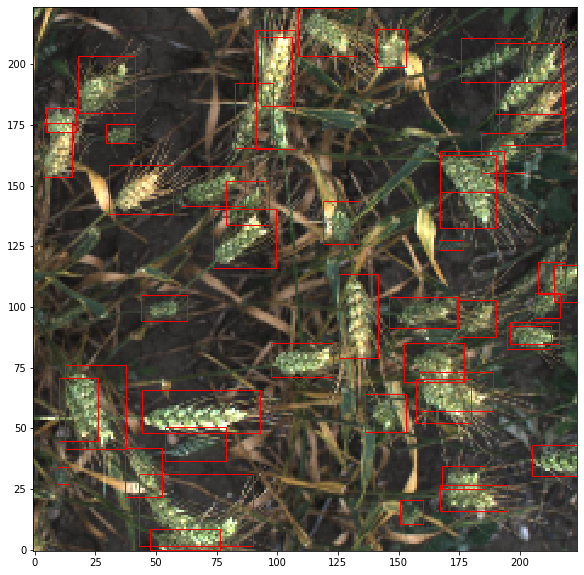

In [20]:
size = 10
sample_id  = list(train_df['image_id'])[0]
img = read_img(f'{data_path}/train/{sample_id}.jpg',target_size)
boxes = train_df[train_df.image_id == sample_id ][['x', 'y', 'w', 'h']].values
scale = train_df[train_df.image_id == sample_id ][['x_scale','y_scale']].values

fig,ax = plt.subplots(1,figsize = (size,size))

img,new_boxes = random_rotation(img,boxes)

ax.imshow(img,origin='lower')

for box,scale in zip(new_boxes,scale):
    x,y,w,h = box
    x_scale,y_scale=scale
    #print(cx,cy,w,h)
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

#print(sample_id)   

In [21]:
image_ids = train_df['image_id'].unique()
fraction = 0.2
valid_ids = image_ids[:int(len(image_ids)*fraction)]
train_ids = image_ids[int(len(image_ids)*fraction):]

In [22]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [23]:
valid_df.shape, train_df.shape,len(image_ids)

((29438, 10), (118355, 10), 3373)

# NN

In [24]:
image_mean= np.array([0.485, 0.456, 0.406])
image_std = np.array([0.229, 0.224, 0.225])
#pretrained # https://pytorch.org/docs/stable/torchvision/models.html

In [25]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None, test=False):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.istest = test


    def __len__(self):
        return self.image_ids.shape[0]

    def __getitem__(self, index):
        
        image_id = self.image_ids[index]

        if(self.istest==False):
            image =  read_img(f'{self.image_dir}/train/{image_id}.jpg',target_size)
        elif(self.istest):
            image =  read_img(f'{self.image_dir}/test/{image_id}.jpg',target_size)
        
        
        image = image/255.0
        image = (image - image_mean) / image_std
        
        
        if(self.istest):
            image = image.transpose((2, 0, 1))
            image = torch.from_numpy(image).float()
            image = torch.as_tensor(image, dtype=torch.float32)
            #sample = {
            #    'image': image,
            #}
            #sample = self.transforms(**sample)
            #image = sample['image']
            
            return image,image_id  
        
        records = self.df[self.df['image_id'] == image_id]   
        boxes = records[['x', 'y', 'w', 'h']].values
        image,boxes = random_rotation(image,boxes)

        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image).float()
        image = torch.as_tensor(image, dtype=torch.float32)
        
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        #boxes /= rescale_factor 
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        #if self.transforms:
        #    sample = {
        #        'image': image,
        #        'bboxes': target['boxes'],
        #        'labels': labels
        #    }
        #    sample = self.transforms(**sample)
        #    image = sample['image']
        

        return image, target,image_id  

In [26]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [27]:
train_dataset = WheatDataset(train_df, data_path)
valid_dataset = WheatDataset(valid_df, data_path)


train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


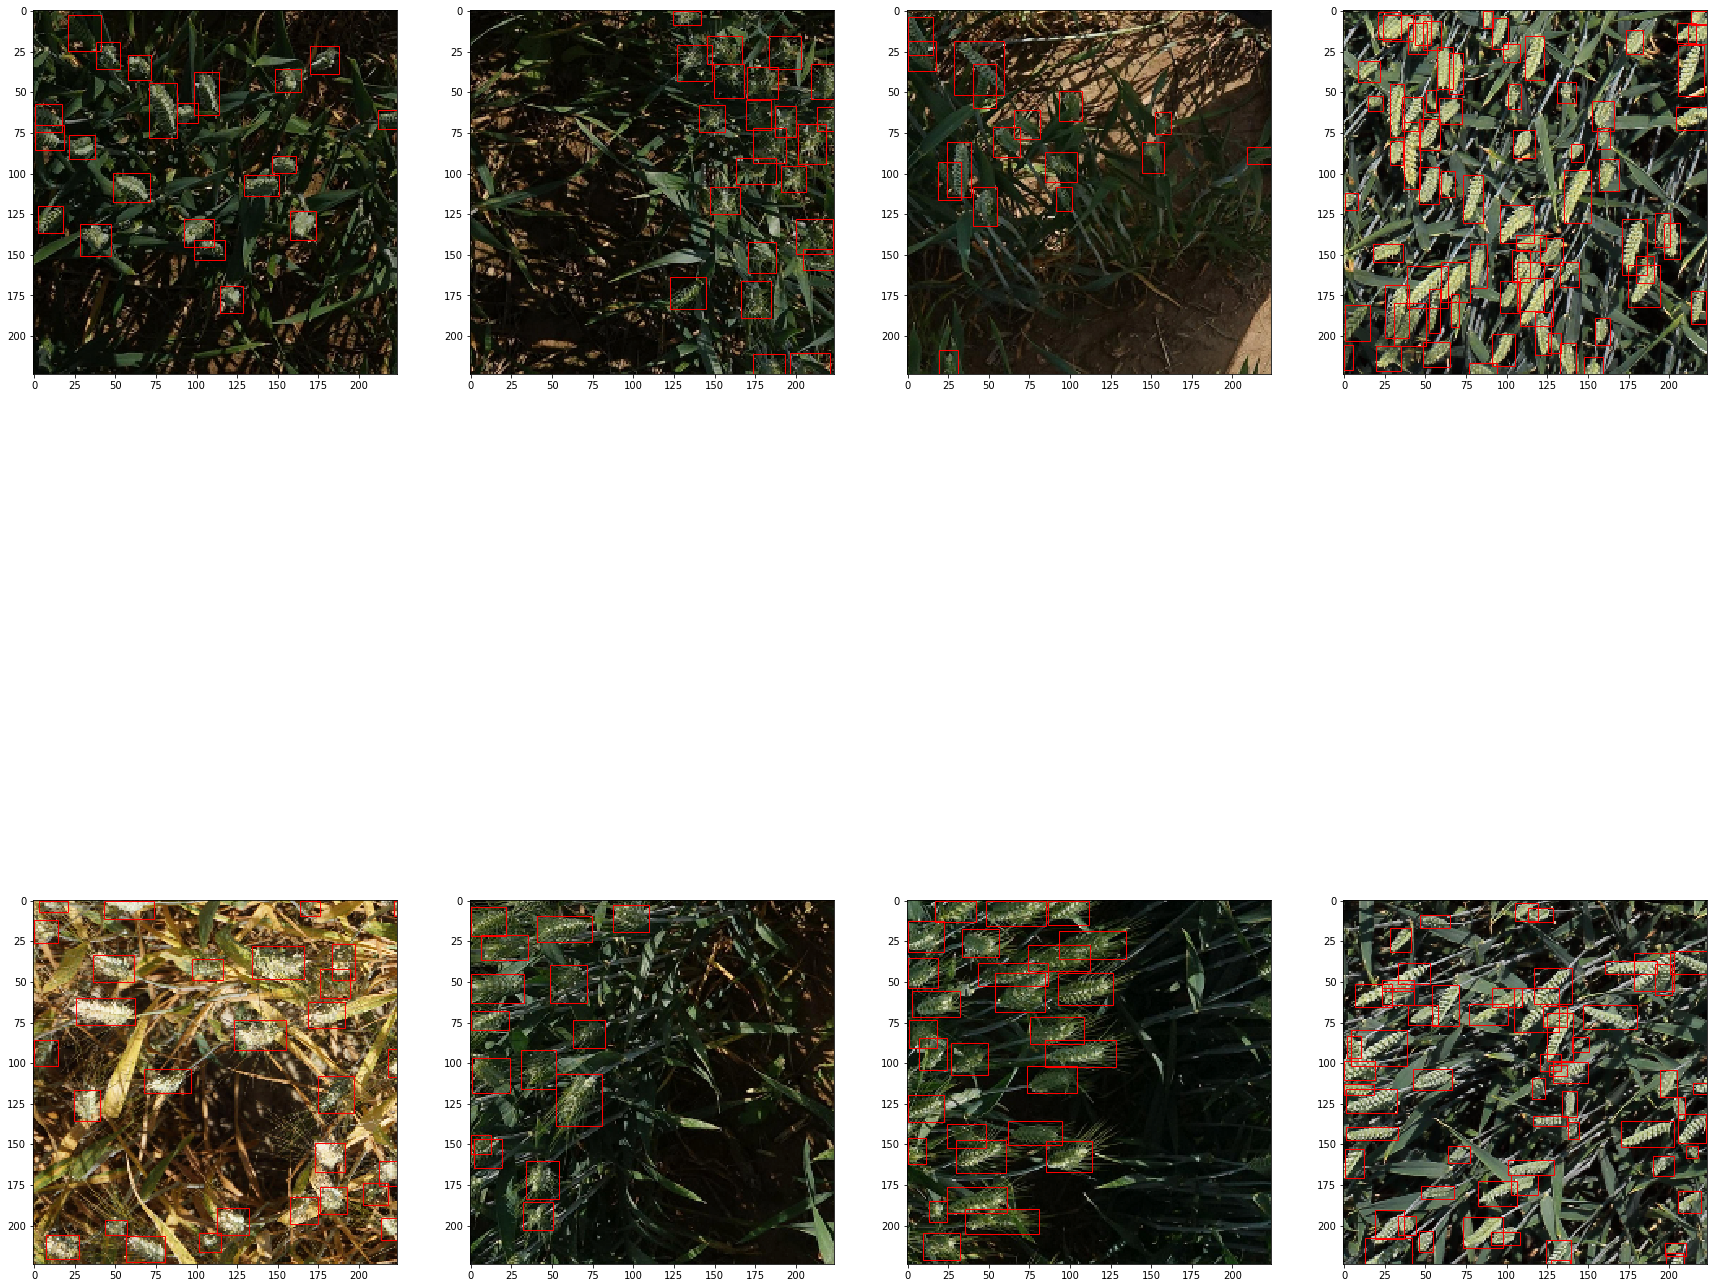

In [28]:
image,target,img_id = next(iter(train_loader))
#print(img)
size = 30
fig,ax = plt.subplots(2,4,figsize = (size,size))
for i in range(2):
    for j in range(4):


        img = image[i*4+j].cpu().numpy().transpose((1,2,0)) 
        img *= image_std
        img += image_mean

        size = 10
        #print(target[0]['boxes'])

        for box in target[i*4+j]['boxes']:
            x,y,w,h = box.cpu().numpy()
            #print(cx,cy,w,h,x_scale,y_scale)
            rect = patches.Rectangle((x,y),w-x,h-y,linewidth=1,edgecolor='r',facecolor='none')
            ax[i][j].add_patch(rect)
        ax[i][j].imshow(img)

In [29]:
# load a model
pretrained_dir=''
import os
for dirname, _, filenames in os.walk('/kaggle/input/fasterrcnn-resnet50-fpn'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        if('fasterrcnn_resnet50' in filename):
            pretrained_dir = os.path.join(dirname, filename)

if(pretrained_dir!=''):
  pretrained_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
  pretrained_model.load_state_dict(torch.load(pretrained_dir))
else:
  pretrained_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
model =  pretrained_model

In [30]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [31]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [32]:
itr = 0
epoch=0
start = time.time()
max_time = 1800 #time limit in second #30 min is enough with a GTX1080
while(time.time()-start<max_time):
    train_loss = []
    for images, targets, image_ids in train_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss.append(loss_value)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    
    print(f"Epoch #{epoch} loss: {np.mean(train_loss)}")   
    epoch +=1

Iteration #0 loss: 2.754188299179077
Iteration #50 loss: 1.1754347085952759
Iteration #100 loss: 0.9373354911804199
Iteration #150 loss: 0.7961122989654541
Iteration #200 loss: 0.9702545404434204
Iteration #250 loss: 0.7107041478157043
Iteration #300 loss: 0.8676950931549072
Epoch #0 loss: 0.9295767371118422
Iteration #350 loss: 0.7018811106681824
Iteration #400 loss: 0.7295156717300415
Iteration #450 loss: 0.7629056572914124
Iteration #500 loss: 0.6494680643081665
Iteration #550 loss: 0.7022587656974792
Iteration #600 loss: 0.790971040725708
Iteration #650 loss: 0.734284520149231
Epoch #1 loss: 0.7425682664622922
Iteration #700 loss: 0.6956981420516968
Iteration #750 loss: 0.7487200498580933
Iteration #800 loss: 0.6207860112190247
Iteration #850 loss: 0.7038555145263672
Iteration #900 loss: 0.6874330043792725
Iteration #950 loss: 0.724231481552124
Iteration #1000 loss: 0.698817789554596
Epoch #2 loss: 0.7038575393208385
Iteration #1050 loss: 0.6759870052337646
Iteration #1100 loss: 0.

In [33]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [34]:


test_dataset = WheatDataset(submit, data_path,test=True)


test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)


In [35]:
detection_threshold = 0.4
results = []
model.eval()
for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        boxes = boxes/target_size*1024
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        #print(result)
        results.append(result)


In [36]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,aac893a91,0.9603 452.57142857142856 854.8571428571429 82...
1,51f1be19e,0.9553 278.85714285714283 475.42857142857144 1...
2,f5a1f0358,0.9705 603.4285714285714 731.4285714285714 96....
3,796707dd7,0.9583 900.5714285714286 333.7142857142857 100...
4,51b3e36ab,0.9809 544.0 32.0 228.57142857142856 128.0 0.9...


In [37]:
sample_id = np.random.choice(test_df['image_id'])


In [38]:
boxes=test_df[test_df['image_id']==sample_id]['PredictionString']
boxes=str(boxes.values).replace('[','')
boxes=boxes.replace(']','')
boxes=boxes.replace('\'','')
boxes = list(boxes.split(" "))
boxes = np.array(boxes).astype('float')
boxes = boxes.reshape(-1,5)

In [39]:
boxes[0]

array([  0.9705    , 603.42857143, 731.42857143,  96.        ,
        86.85714286])

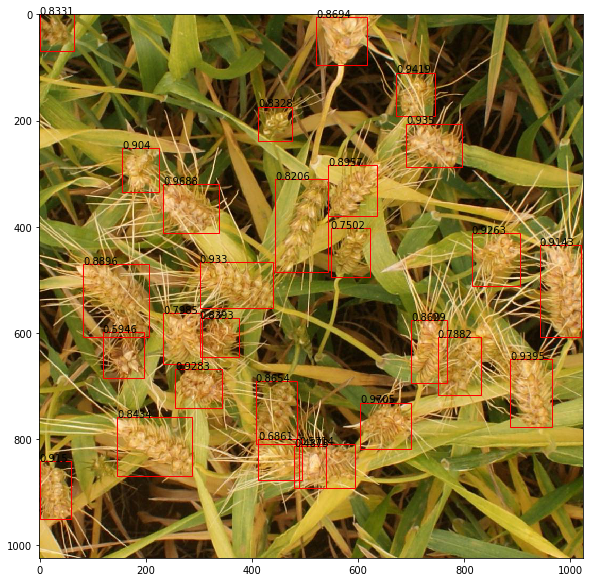

In [40]:
size = 10
img =  read_img(f'{data_path}/test/{sample_id}.jpg',1024)
fig,ax = plt.subplots(1,figsize = (size,size))
ax.imshow(img)
for box in boxes:
    x,y,w,h = box[1:]
    s = box[0]
    ax.text(x,y,str(s))
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.savefig("FRCNN.png",format="png")